In [ ]:
# import numpy as np
# import torch
# import matplotlib.pyplot as plt
# import cv2
# import os
# import pickle
# from segments import SegmentsClient
# import json
# import pandas as pd
# from segments.utils import load_image_from_url, load_label_bitmap_from_url

In [6]:
import sys
sys.path.append("..")
from annotations.segmentsai import *
from annotations.ploting import *
from preprocess.image_preprocess import *
from dl_segmentation.sam import *
from dl_segmentation.sam_measurments import *


In [7]:
client = setup_connection_segmentsai()
dataset = 'etaylor/trichomes_moment_lens_instance_segmentation'
sample = client.get_samples(dataset)

In [ ]:
ground_truth = build_ground_truth_dict(dataset, client)

# Read Images

In [ ]:
patches_path = "/sise/home/etaylor/images/trichomes_patches/week5_3xzoom_regular_best_images"
images_names = read_images_and_names(patches_path)

# SAM

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    # !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [ ]:
sam, mask_generator = setup_sam()

Run the SAM model on the image patches

# New Session begin

In [ ]:
import pickle

with open('/home/etaylor/images/trichomes_patches/week5_3xzoom_regular_best_images/analysis/SAM_pred.pickle', 'rb') as f:
    SAM_pred = pickle.load(f)

with open('/home/etaylor/images/trichomes_patches/week5_3xzoom_regular_best_images/analysis/ground_truth.pickle', 'rb') as f:
    ground_truth = pickle.load(f)

In [ ]:
# SAM_pred = segments_patches_SAM(images_names, mask_generator)

# Measure SAM scores with default settings

Calculate average metrics for images

In [ ]:
# Call the function
average_precision, average_recall, std_dev_precision, std_dev_recall, (total_TPs, total_FPs, total_FNs), all_iou_values = calculate_average_precision_recall(ground_truth, SAM_pred, iou_threshold=0.95)

print(f'Average precision: {average_precision}, Standard deviation: {std_dev_precision}')
print(f'Average recall: {average_recall}, Standard deviation: {std_dev_recall}')

plot_confusion_matrix(total_TPs, total_FPs, total_FNs)

Calculate metrics for each image

In [ ]:
for sample in ground_truth.keys():
  print(f"----------- Analysis for {sample} ----------- \n")
  plot_masks(ground_truth[sample], SAM_pred[sample])
  precision, recall, (TPs, FPs, FNs), iou_values = calculate_precision_recall_per_segment(ground_truth[sample], SAM_pred[sample], iou_threshold=0.5)
  print(f"--- Precision = {precision}, Recall = {recall}---\n")
  plot_confusion_matrix(TPs, FPs, FNs)
  plot_iou_histogram(iou_values)

## Save ground truth and sam preditions

In [ ]:
import pickle

with open("SAM_pred.pickle", "wb") as f:
    pickle.dump(SAM_pred, f)

with open("ground_truth.pickle", "wb") as f:
    pickle.dump(ground_truth, f)

# Extract Trichomes from Segmentations

In [ ]:
def plot_segments_one_by_one(image, masks):
    # Sort the masks by area in descending order
    sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=True)

    # Iterate over all masks
    for i, mask in enumerate(sorted_masks, start=1):
        # Extract bounding box coordinates
        x, y, width, height = mask['bbox']

        # Use the bounding box coordinates to extract the segment from the image
        segment = image[y:y+height, x:x+width]

        # Plot the segment
        plt.figure(figsize=(5, 5))
        plt.imshow(segment)
        plt.axis('off')
        plt.title(f'Segment {i}')
        plt.show()



def show_anns_numbered(anns):
    # If there are no annotations, exit the function early
    if len(anns) == 0:
        return

    # Sort the annotations by area in descending order
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)

    # Get the current axis (plot) on which to draw
    ax = plt.gca()
    # Disable autoscaling of the axis
    ax.set_autoscale_on(False)

    # Create a transparent image of the same size as the first (largest) annotation
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0

    # Loop over each annotation
    for i, ann in enumerate(sorted_anns):
        # Get the mask for this annotation
        m = ann['segmentation']

        # Generate a random color for this mask (RGB + alpha, where alpha is 0.35)
        color_mask = np.concatenate([np.random.random(3), [0.35]])

        # Apply the color to the mask on the image
        img[m] = color_mask

        # Calculate the centroid of the mask
        y, x = np.argwhere(m).mean(axis=0)

        # Add a text label with the segment number at the centroid of the mask
        plt.text(x, y, str(i+1), color='white', fontsize=12, ha='center', va='center')

    # Display the image with the colored masks
    ax.imshow(img)



def plot_all_segments(image, masks):
    # Create a figure and axes
    fig, ax = plt.subplots(1, figsize=(10, 10))

    # Display the image
    ax.imshow(image)

    # Call the function to overlay the masks
    show_anns_numbered(masks)

    # Hide the axes
    ax.axis('off')

    plt.show()

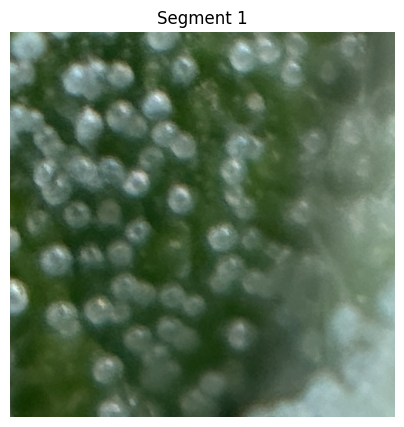

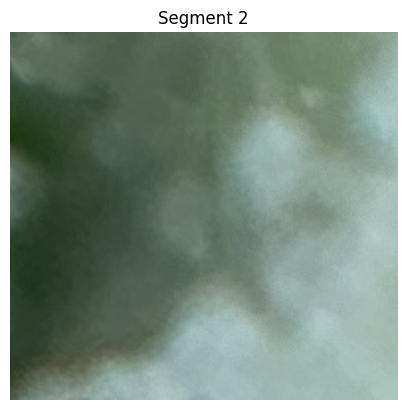

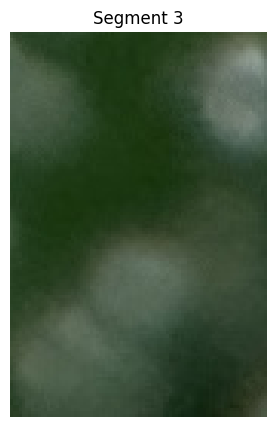

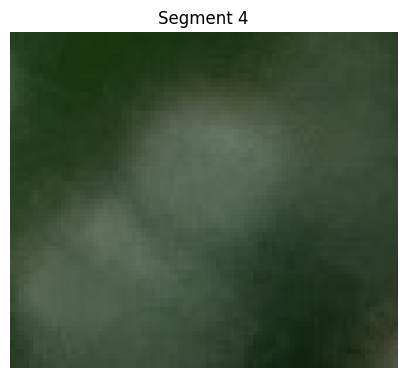

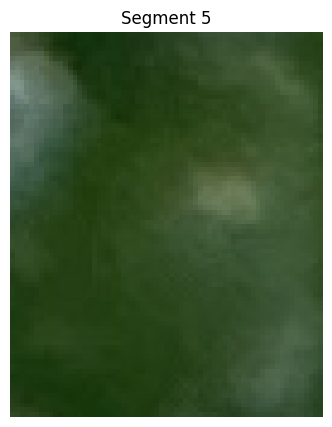

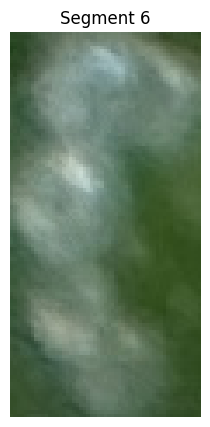

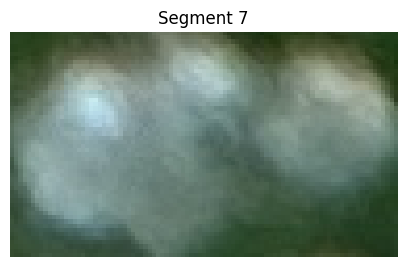

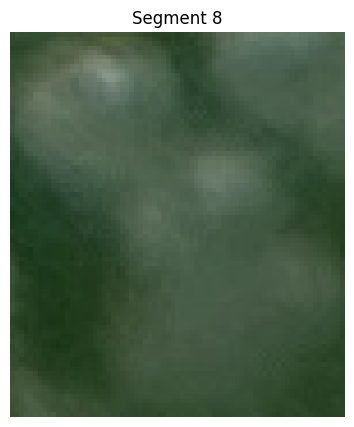

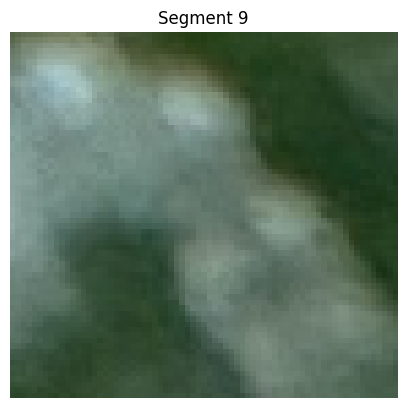

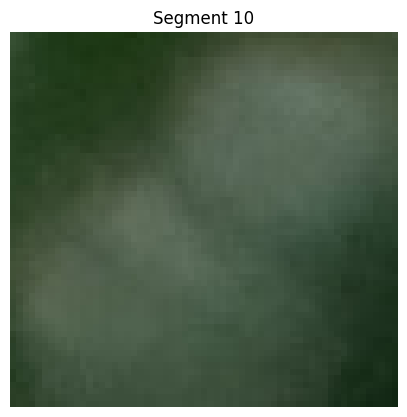

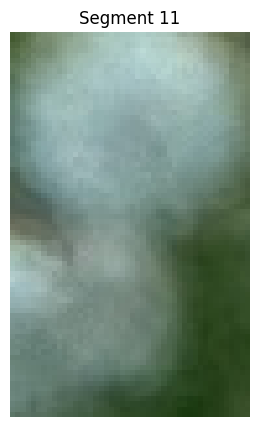

KeyboardInterrupt: 

In [5]:
# Convert PIL image to NumPy array
image_array = np.array(ground_truth['IMG_9998_p19']['image'])

# Call the functions
plot_segments_one_by_one(image_array, SAM_pred['IMG_9998_p19']['mask'])

In [ ]:
plot_all_segments(image_array, SAM_pred['IMG_9998_p19']['mask'])

In [ ]:
plt.imshow(image_array)

By looking on those images i think we can determine huristics for removing segments that did not succeeded to segment the trichomes.
Examples for segments that can be removed:

*   All image segment
*   Big parts segments
*   segments that overlap over a certain IOU threshold

